<a href="https://colab.research.google.com/github/wisrovi/RedesNeuronales/blob/master/07MAIR-WilliamSteveRodriguezVillamizar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://drive.google.com/drive/folders/1w2w5dAF269C646RBwwU33YLNUG4JRfh9?usp=sharing

https://github.com/wisrovi/RedesNeuronales/blob/master/07MAIR-WilliamSteveRodriguezVillamizar.ipynb



# 0. Nota sobre notebook (leer antes de ejecutar otra linea)

## 0.0. 
Tanto para el ejercicio de crear la red neuronal desde cero como para las redes neuronales por transferencia de conocimiento se aumento el dataseet de datos con ImageGenerator en cuatro (4) veces el tamaño original [No se pudo aumentar más veces debido a que el entorno de ejecución por mi GPU no lo permitió], esto para que los modelos entrenados tuvieran más generalización en los datos y con esto tuviera mejor respuesta en los test y predict.

## 0.1.
Antes de efectuar cualquier carga del programa se debe iniciar el sistema ejecutando todos los codigos del apartado 2. Iniciar Sistema, teniendo la opción de omitir, si se desea el apartado 2.7. Aumentar el set de datos con DataGenerator (Opcional pero mejora los modelos cuando se utiliza)

## 0.2. 
Para evaluar la red Neuronal creada desde cero se puede ir al punto 3.3 Cargar Modelo Red Neuronal Guardado (Nueva red neuronal desde cero)

## 0.3. 
Para los dos modelos por transferencia de conocimiento se ha utilizado los modelos preentrenados de VGG16 y MobileNetV2, y para los dos y para hacer mejor las comparaciones, se ha creado a posterior el mismo modelo de entrenamiento y se has descongelado la misma cantidad de capas del modelo preentrenado (5), esto para evaluar conforme al modelo y determinar cual de los dos modelos preentrenados es mejor para este conjunto de datos.

## 0.4.
Para evaluar el modelo por transferencia de conocimiento (Usando VGG16) puede ir directamente al apartado 4.5. Cargar Modelo Red Neuronal Guardado (Transferencia conocimiento)

## 0.5.
Para evaluar el modelo por transferencia de conocimiento 2 (Usando MobileNetV2) puede ir directamente al apartado 5.5. Cargar Modelo Red Neuronal Guardado (Transferencia conocimiento)

## 0.6.
El Base Folder se puede modificar en el apartado 2.2. Conexion con Google y Drive

## 0.7.
Se ha incorporado en este proyecto algunas librerias propias que se encuentran en el mismo drive, para facilitar el procesamiento del código

# 1. Bibliografia

In [0]:
#urlArchivos = "https://drive.google.com/drive/folders/1w2w5dAF269C646RBwwU33YLNUG4JRfh9?usp=sharing"

In [0]:
#!pip install tensorflow==2.0.0-alpha0

In [0]:
#https://github.com/jbagnato/machine-learning
#https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python#cnn
#https://www.datacamp.com/community/blog/keras-cheat-sheet
#https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
#https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
#https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
#https://www.aprendemachinelearning.com/clasificacion-de-imagenes-en-python/

# 2. Iniciar Sistema

## 2.1. Importar Librerias

In [4]:
#instalo las librerias necesarias
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU

#importo las librerias que se van a necesitar
import pickle
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from numpy import expand_dims

from keras import models
from keras import layers

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical #para que las salidas queden parametrizadas en binario

from sklearn.metrics import classification_report #para ver parametros 

from keras.applications.inception_v3 import decode_predictions #para ver varios items de prediccion

#para autoescalar la imagen al tamaño requerido por la red a reentrenar
from keras.applications.inception_v3 import preprocess_input

#Incrementar el número de ejemplos para evitar overfitting (junto con dropout)
#Generar datos a partir de los presentes, a través de transformaciones
from keras.preprocessing.image import ImageDataGenerator



# Para las librerias para la red neuronal
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

#callback para mejorar los entrenamientos
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  

Using TensorFlow backend.


## 2.2. Conexion con Google y Drive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
###################################################################################################
BASE_FOLDER = '/content/gdrive/My Drive/Master IA/Redes Neuronales/'
###################################################################################################

In [0]:
#le indicamos al colaboratory que las importaciones de librerias propias se haran tambien desde el directorio base
import sys
sys.path.append(BASE_FOLDER)

## 2.3 Importar Librerias propias

In [0]:
from ModeloExterno import ModeloExterno

## 2.4. Funciones

In [0]:
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def getRam_y_Gpu(imprimir=False):
  process = psutil.Process(os.getpid())
  ram_available = psutil.virtual_memory().available
  ram_disponible = humanize.naturalsize( ram_available  )
  gpu_disponible = gpu.memoryFree
  if imprimir:
      print("Gen RAM Free: " + ram_disponible, " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
      print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu_disponible, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  ram_available = ram_available / 1000000000
  ram_available = round(ram_available, 2)
  return (ram_available, gpu_disponible)

#Algunas funciones utiles
def plot_image(img, title=""):
    #plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(title)
    #plt.axis('off')
    plt.show()

def convertLabelsToNumbers(y_train):
    # Transformando las labels de texto a valores numéricos
    y = np.unique(y_train)
    mapping = { key : value for key,value in zip(y,range(len(y)))}
    processed_y = np.array([mapping[i] for i in y_train])
    #print(len(mapping))
    return processed_y

def DividirDatos_Train_Test_Predic(x, y, porcentaje=0.25, randomDiv=50):
    print("Datos para división recibidos")

    # dividir los datos entre training, test y predic
    X_train, X_test, y_train, y_test = train_test_split(
        x_train_all, processed_y, 
        test_size=porcentaje, 
        random_state=randomDiv)
    print("División todo el dataset en: train y test completa")

    X_test, X_predic, y_test, y_predic = train_test_split(
        X_test, y_test, 
        test_size=porcentaje, 
        random_state=randomDiv)
    print("División dataset test en: test y predict completa")
    
    #Hacemos el One-hot Encoding
    train_Y_one_hot = to_categorical(y_train)
    test_Y_one_hot = to_categorical(y_test)
    predic_Y_one_hot = to_categorical(y_predic)
    print("Conversión de salidas en categorias completa")

    return (X_train, train_Y_one_hot), (X_test, test_Y_one_hot), (X_predic, predic_Y_one_hot)

def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['acc'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_pred(pred):
    plt.figure(figsize=(8, 2))
    classes = [c[1] for c in pred]
    probas = [c[2] for c in pred]
    y_pos = np.arange(len(classes))
    plt.barh(y_pos, probas, align='center')
    plt.yticks(y_pos, classes)
    plt.gca().invert_yaxis()
    plt.xlabel('Probability')
    plt.xlim(0, 1)

def DefineCallback(nameFileIfSave): #guardar el mejor modelo w.r.t en val_losses
    """
    Agradecimientos a Data Talks, 
    url: https://www.youtube.com/watch?v=Gl-N3xr5zLI
    """    
    #EarlyStopping, detener el entrenamiento una vez que su pérdida comienza a aumentar 
    early_stop = EarlyStopping(
        monitor='val_loss', 
        patience=5, #argumento de patience representa el número de épocas antes de detenerse una vez que su pérdida comienza a aumentar (deja de mejorar). 
        min_delta=0,  #es un umbral para cuantificar una pérdida en alguna época como mejora o no. Si la diferencia de pérdida es inferior a min_delta , se cuantifica como no mejora. Es mejor dejarlo como 0 ya que estamos interesados ​​en cuando la pérdida empeora.
        mode='auto')
        
    mcp_save = ModelCheckpoint(
        nameFileIfSave + 'model-{acc:03f}-{val_acc:03f}.h5', 
        monitor='val_loss',
        save_best_only=True, 
        mode='min')

    #ReduceLROnPlateau, que si el entrenamiento no mejora tras unos epochs específicos, reduce el valor de learning rate del modelo
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.1, 
        patience=5, 
        epsilon=1e-4, 
        mode='min')
    
    callbacks_list = [early_stop, reduce_lr, mcp_save]  
    return callbacks_list

#hago las conversiones a la imagen
dataAumentationApliqued = False
def ConverImageUsingImageDataGenerator(datagen, imagen, nombre, cantidadConversiones):
    listaConversiones = []
    listaEtiquetasCadaConversion = []
    imagen4dimensiones = expand_dims(imagenConvertir, 0)
    imagen3dimensiones = np.squeeze(imagen4dimensiones)
    listaConversiones.append(convertNumpyToList(imagen3dimensiones))

    iterator_datagen_train = datagen.flow(imagen4dimensiones, batch_size=1)

    for i in range(cantidadConversiones):
        batch = iterator_datagen_train.next()
        image = np.squeeze(batch[0])
        listaConversiones.append(convertNumpyToList(image))

    for i in range(len(listaConversiones)):
        listaEtiquetasCadaConversion.append(nombreImagen)
    

    return listaConversiones, listaEtiquetasCadaConversion

def convertNumpyToList(imagenNumpy):
    return list(imagenNumpy)

def convertListoToNumpy(imagenList):
    return array(imagenList)

def getModelTransferLearning(baseModel):
    model = models.Sequential()
    model.add(baseModel)

    model.add(Dropout(0.25)) #apagar un 25% de manera aleatoria para reducir la cantidad de parametros


    model.add(
        Conv2D(32,
              kernel_size=(3, 3),
              activation='relu',
              padding='same',
              input_shape=(128,128,3)
              )
        )

    model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'  ) )

    model.add(Dropout(0.25)) #apagar un 25% de manera aleatoria para reducir la cantidad de parametros

    #para aplanar todas las capas
    #esto se hace debido a que el modelo de VG16 nos da 4 dimensiones de salida, y con esto reducimos las dimensiones a dos: numero datos, numero clases
    model.add(Flatten()) 

    # conectarlo a nueva parte densa
    # Genero la capa final con la cantidad de neuronas segun la cantidad de opciones de clasificacion
    model.add(Dense(nClasses, activation='softmax')) 

    model.summary()

    # compilar el modelo
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [10]:
ramColab, GpuColab = getRam_y_Gpu(True)

Gen RAM Free: 26.1 GB  | Proc size: 370.3 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


## 2.5. Importar Dataseet y clases

In [11]:
#Cargo los archivos de clases y las imagenes
with open(BASE_FOLDER+"pickle_all_images_df-002.pickle", "rb") as input_file:
    x_train_all = pickle.load(input_file)
with open(BASE_FOLDER+"pickle_all_classes.pickle", "rb") as input_file:
    y_train_all = pickle.load(input_file)

number_of_classes = len(y_train_all)

print("Entradas: ",x_train_all.shape)
print("Salidas: ", number_of_classes)

Entradas:  (9145, 128, 128, 3)
Salidas:  9145


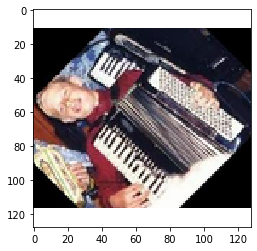

In [12]:
#show a image
plot_image(x_train_all[15])

## 2.6. Repartir Datos entre train-test-predic

In [13]:
print("Cantidad imagenes: ", len(x_train_all))
print("Cantidad etiquetas: ", len(y_train_all))

Cantidad imagenes:  9145
Cantidad etiquetas:  9145


In [14]:
processed_y = convertLabelsToNumbers(y_train_all)
salidasCategoricas = to_categorical(processed_y)

classesImageGenerator = np.unique(salidasCategoricas)
nClassesImageGenerator = len(salidasCategoricas[1])
print("Cantidad de categorias en las clases",nClassesImageGenerator)

Cantidad de categorias en las clases 102


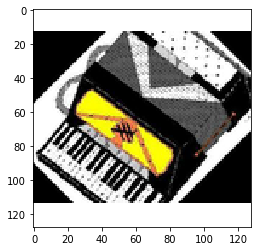

5 accordion


In [15]:
imagen = 7
plot_image(x_train_all[imagen])
print(processed_y[imagen], y_train_all[imagen])

In [16]:
classes = np.unique(processed_y)
nClasses = len(classes)

(X_train, y_train), (X_test, y_test), (X_predic, y_predic) = DividirDatos_Train_Test_Predic(x_train_all, processed_y)

print("Training (66.98%)") 
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print() 
print("Test (22.1%)") 
print("X_test", X_test.shape)
print("y_test", y_test.shape)
print()
print("Predict (10.89%)") 
print("X_predic", X_predic.shape)
print("y_predic", y_predic.shape)

print()
if y_predic.shape[1] == y_test.shape[1] and y_test.shape[1] == y_train.shape[1]:
    print("Distribución correcta")
else:
    print("Fallo en la distribución")

Datos para división recibidos
División todo el dataset en: train y test completa
División dataset test en: test y predict completa
Conversión de salidas en categorias completa
Training (66.98%)
X_train (6858, 128, 128, 3)
y_train (6858, 102)

Test (22.1%)
X_test (1715, 128, 128, 3)
y_test (1715, 102)

Predict (10.89%)
X_predic (572, 128, 128, 3)
y_predic (572, 102)

Distribución correcta


In [0]:
x_all = x_train_all
y_all = train_Y_one_hot = to_categorical(processed_y)

## 2.7. Aumentar el set de datos con DataGenerator (Opcional pero mejora los modelos cuando se utiliza)

### 2.7.1 Creando el modelo generador de datos

In [0]:
#Creamos el datagen del ImageDataGenerator para definir que cambios podria tener la imagen original

datagen = ImageDataGenerator(
    rotation_range=25, # grados de rotacion aleatoria
    width_shift_range=0.15, # fraccion del total (1) para mover la imagen
    height_shift_range=0.15, # fraccion del total (1) para mover la imagen
    shear_range=0.05, # deslizamiento
    zoom_range=0.1, # rango de zoom
    horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
    fill_mode='nearest', # como rellenar posibles nuevos pixeles
    channel_shift_range=0.2 # cambios aleatorios en los canales de la imagen
)

### 2.7.2.Aplicando el data aumentation en el dataset original

In [19]:
cantidadConversiones = 2
#probado y funcionando con valor de 4, pero se requiere una buena GPU
#porque es facil superar la RAM maxima, y cuando se supera el colab ya no funciona



#También se incluirá la imagen original (en la practica no se suele usar la imagen original, pero para tener un dataset más grande en esta oportunidad la incluiremos)


if dataAumentationApliqued == False:
    print("Cantidad imagenes iniciales: ", len(X_train))
    print("Cantidad etiquetas iniciales: ", len(y_train))
    print("Tipo datos iniciales: ", type(X_train))
    listadoImagenes = []
    listaEtiquetasImagen = []
    for imagenProcesar in range(len(X_train)):    
        imagenConvertir = X_train[imagenProcesar] #elijo la imagen a usar de todo el dataset
        nombreImagen = y_train[imagenProcesar]
        listaConversiones, listaEtiquetasCadaConversion = ConverImageUsingImageDataGenerator(datagen, imagenConvertir, nombreImagen, cantidadConversiones-1)
        #añado las conversiones a la lista con append
        for i in range(len(listaConversiones)):
            listadoImagenes.append(listaConversiones[i])
            listaEtiquetasImagen.append(listaEtiquetasCadaConversion[i])

    #convierto la lista nuevamente a numpy para entregarla a los modelos
    X_train = convertListoToNumpy(listadoImagenes)
    y_train = convertListoToNumpy(listaEtiquetasImagen)
    print()
    print("Cantidad imagenes finales: ", len(X_train))
    print("Cantidad etiquetas finales: ", len(y_train))
    print("Tipo datos finales: ", type(X_train))
    dataAumentationApliqued = True
else:
    print("No se puede aplicar dataAumentation varias veces, si desea usarlo nuevamente, vuelva a reiniciar el colab (disponible en el menú de 'Entorno de ejecución').")

Cantidad imagenes iniciales:  6858
Cantidad etiquetas iniciales:  6858
Tipo datos iniciales:  <class 'numpy.ndarray'>

Cantidad imagenes finales:  13716
Cantidad etiquetas finales:  13716
Tipo datos finales:  <class 'numpy.ndarray'>


In [20]:
ramColab, GpuColab = getRam_y_Gpu(False)
if ramColab < 4:
    print("La Ram disponible no es suficiente para los entrenamientos de la red neuronal.")
else:
    getRam_y_Gpu(True)

Gen RAM Free: 16.4 GB  | Proc size: 14.6 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


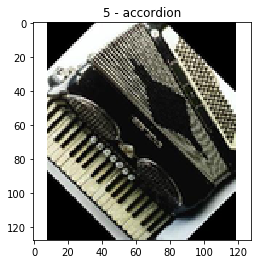

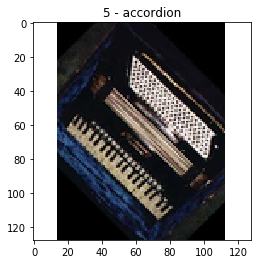

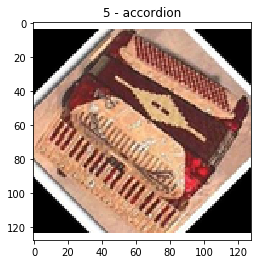

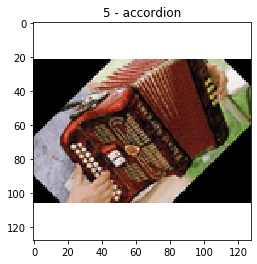

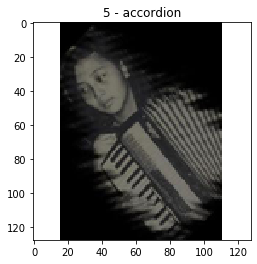

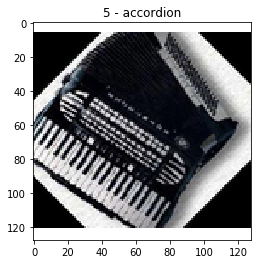

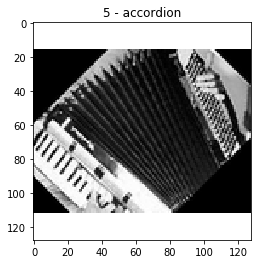

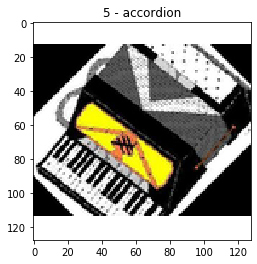

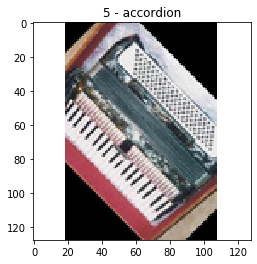

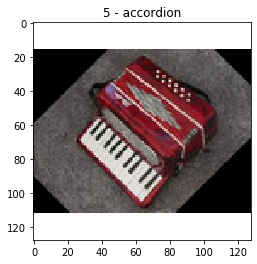

In [21]:
for imagen in range(10):
    titulo = str(processed_y[imagen]) + " - " + y_train_all[imagen]
    plot_image(x_train_all[imagen], titulo)

## 2.8. Repartir datos en valid y train

In [22]:
ramColab, GpuColab = getRam_y_Gpu(False)
if ramColab < 4:
    print("La Ram disponible no es suficiente para los entrenamientos de la red neuronal.")
else:
    getRam_y_Gpu(True)

Gen RAM Free: 16.4 GB  | Proc size: 14.6 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [23]:
print(X_train.shape, y_train.shape)

(13716, 128, 128, 3) (13716, 102)


In [24]:
train_X, valid_X, train_label, valid_label = train_test_split(
        X_train, y_train, 
        test_size=0.2, 
        random_state=10)

print(X_train.shape, y_train.shape)
print(valid_X.shape, valid_label.shape)

(13716, 128, 128, 3) (13716, 102)
(2744, 128, 128, 3) (2744, 102)


In [25]:
ramColab, GpuColab = getRam_y_Gpu(False)
if ramColab < 4:
    print("La Ram disponible no es suficiente para los entrenamientos de la red neuronal.")
else:
    getRam_y_Gpu(True)

Gen RAM Free: 11.0 GB  | Proc size: 20.0 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


# 3. Nueva Red Neuronal

In [26]:
ramColab, GpuColab = getRam_y_Gpu(False)
if ramColab < 3:
    print("La Ram disponible no es suficiente para los entrenamientos de la red neuronal.")
else:
    getRam_y_Gpu(True)

Gen RAM Free: 11.0 GB  | Proc size: 20.0 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [0]:
nombreModeloCreado = "wisrovi-nuevoModelo"
modelExtern = ModeloExterno(nombreModelo=nombreModeloCreado, rutaBase=BASE_FOLDER)

## 3.1. Modelo Red Neuronal

In [28]:
print("********** Modelo *********")
#MaxPooling2D es una forma de reducir el número de parámetros en nuestro modelo deslizando un filtro de agrupación de 2x2 a través de la capa anterior 
#y tomando el máximo de los 4 valores en el filtro de 2x2.

new_model = Sequential()
new_model.add( Conv2D(32,  kernel_size=(3, 3), activation='relu',padding='same', input_shape=(128,128,3))  )
new_model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'  ) )
new_model.add(MaxPooling2D((2, 2),padding='same'))

new_model.add( Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'  ) )
new_model.add( Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'  ) )
new_model.add( Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'  ) )
new_model.add(MaxPooling2D((2, 2),padding='same'))

new_model.add( Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same'  ) )
new_model.add( Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same'  ) )
new_model.add(MaxPooling2D((2, 2),padding='same'))

new_model.add(Dropout(0.5)) #apagar un 50% de manera aleatoria para reducir la cantidad de parametros

new_model.add(Flatten()) #para aplanar todas las capas
new_model.add(Dense(96, activation='relu'))
new_model.add(Dropout(0.1))
new_model.add(Dense(96, activation='relu'))
new_model.add(Dense(128, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(nClasses, activation='softmax')) #Genero la capa final con la cantidad de neuronas segun la cantidad de opciones de clasificacion

new_model.summary()

new_model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

modelExtern.GuardarModelo(new_model)

********** Modelo *********





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64

True

## 3.2. Entrenar el modelo



Entrenamiento 1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '





Train on 10972 samples, validate on 2744 samples
Epoch 1/11





10972/10972 [==============================] - 24s 2ms/step - loss: 3.9552 - acc: 0.1631 - val_loss: 3.4290 - val_acc: 0.2668
Epoch 2/11
10972/10972 [==============================] - 13s 1ms/step - loss: 3.4857 - acc: 0.2602 - val_loss: 3.3603 - val_acc: 0.2999
Epoch 3/11
10972/10972 [==============================] - 13s 1ms/step - loss: 3.2395 - acc: 0.2959 - val_loss: 3.1074 - val_acc: 0.3189
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 3.0635 - acc: 0.3220 - val_loss: 2.9447 - val_acc: 0.3375
Epoch 5/11
10972/10972 [==============================] - 13s 1ms/step - loss: 2.9146 - acc: 0.3407 - val_loss: 2.7897 - val_acc: 0.3743
Epoch 6/11
10972/10972 [==============================] - 13s 1ms/step - loss: 2.7863 - acc: 0.3586 - val_loss: 2.6941 - val_acc: 0.3863
Epoch 7/11
10972/10972 [==============================] - 13s 1ms/step - loss: 2.6532 - acc: 0.3810 - val_loss: 2.5977 - 

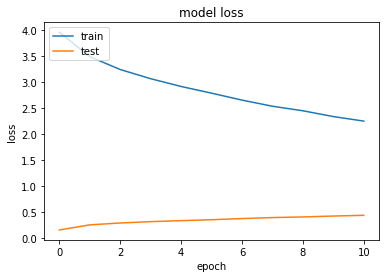

1715/1715 [==============================] - 1s 517us/step
Test loss: 2.204000722423587
Test accuracy: 0.48279883394088413
Pesos Guardados!
***************



Entrenamiento 2
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
  160/10972 [..............................] - ETA: 12s - loss: 2.0683 - acc: 0.4688

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


10972/10972 [==============================] - 13s 1ms/step - loss: 2.2026 - acc: 0.4501 - val_loss: 2.4152 - val_acc: 0.4329
Epoch 2/11
10972/10972 [==============================] - 13s 1ms/step - loss: 2.1310 - acc: 0.4658 - val_loss: 2.4070 - val_acc: 0.4377
Epoch 3/11
10972/10972 [==============================] - 13s 1ms/step - loss: 2.0532 - acc: 0.4811 - val_loss: 2.3607 - val_acc: 0.4457
Epoch 4/11
10972/10972 [==============================] - 13s 1ms/step - loss: 1.9989 - acc: 0.4943 - val_loss: 2.3789 - val_acc: 0.4431
Epoch 5/11
10972/10972 [==============================] - 13s 1ms/step - loss: 1.9056 - acc: 0.5094 - val_loss: 2.3619 - val_acc: 0.4552
Epoch 6/11
10972/10972 [==============================] - 13s 1ms/step - loss: 1.8619 - acc: 0.5195 - val_loss: 2.3871 - val_acc: 0.4541
Epoch 7/11
10972/10972 [==============================] - 13s 1ms/step - loss: 1.8200 - acc: 0.5260 - val_loss: 2.4354 - val_acc: 0.4614
Epoch 8/11
10972/10972 [============================

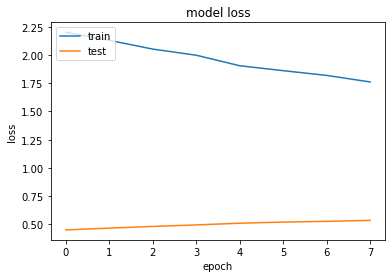

1715/1715 [==============================] - 1s 454us/step
Test loss: 2.0640672291680606
Test accuracy: 0.5154518950089769
Pesos Guardados!
***************



Entrenamiento 3
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 13s 1ms/step - loss: 1.5918 - acc: 0.5753 - val_loss: 2.3447 - val_acc: 0.4745
Epoch 2/11
10972/10972 [==============================] - 13s 1ms/step - loss: 1.5197 - acc: 0.5854 - val_loss: 2.3622 - val_acc: 0.4745
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.5041 - acc: 0.5886 - val_loss: 2.3501 - val_acc: 0.4785
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4866 - acc: 0.5931 - val_loss: 2.3601 - val_acc: 0.4734
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4733 - acc: 0.5935 - val_loss: 2.3707 - val_acc: 0.4759
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4481 - acc

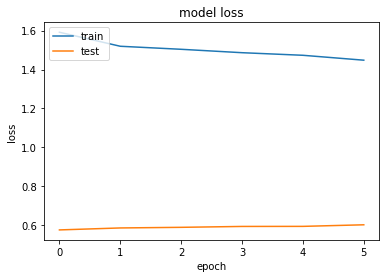

1715/1715 [==============================] - 1s 466us/step
Test loss: 2.024399366045137
Test accuracy: 0.5317784256212218
Pesos Guardados!
***************



Entrenamiento 4
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4232 - acc: 0.6046 - val_loss: 2.3767 - val_acc: 0.4759
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4385 - acc: 0.6044 - val_loss: 2.3721 - val_acc: 0.4767
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4221 - acc: 0.6115 - val_loss: 2.3770 - val_acc: 0.4763
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4188 - acc: 0.6096 - val_loss: 2.3767 - val_acc: 0.4756
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4270 - acc: 0.6084 - val_loss: 2.3772 - val_acc: 0.4778
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4191 - acc:

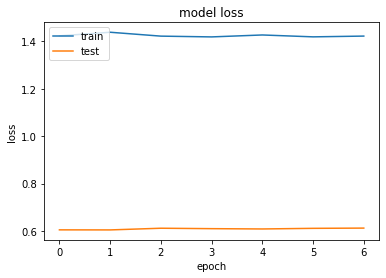

1715/1715 [==============================] - 1s 465us/step
Test loss: 2.0133091973841366
Test accuracy: 0.5411078716853617
Pesos Guardados!
***************



Entrenamiento 5
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4259 - acc: 0.6070 - val_loss: 2.3792 - val_acc: 0.4763
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4066 - acc: 0.6103 - val_loss: 2.3796 - val_acc: 0.4763
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4054 - acc: 0.6130 - val_loss: 2.3803 - val_acc: 0.4767
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4067 - acc: 0.6130 - val_loss: 2.3809 - val_acc: 0.4763
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4143 - acc: 0.6119 - val_loss: 2.3812 - val_acc: 0.4767
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4107 - acc

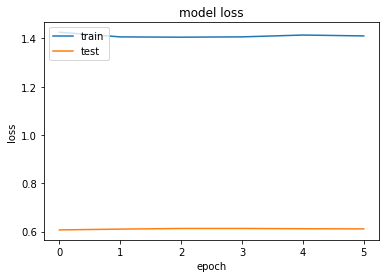

1715/1715 [==============================] - 1s 464us/step
Test loss: 2.0164071785117725
Test accuracy: 0.5416909620643705
Pesos Guardados!
***************



Entrenamiento 6
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4128 - acc: 0.6115 - val_loss: 2.3815 - val_acc: 0.4770
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.3955 - acc: 0.6145 - val_loss: 2.3815 - val_acc: 0.4770
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4025 - acc: 0.6110 - val_loss: 2.3816 - val_acc: 0.4774
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4142 - acc: 0.6087 - val_loss: 2.3816 - val_acc: 0.4774
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4080 - acc: 0.6119 - val_loss: 2.3817 - val_acc: 0.4774
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4089 - acc

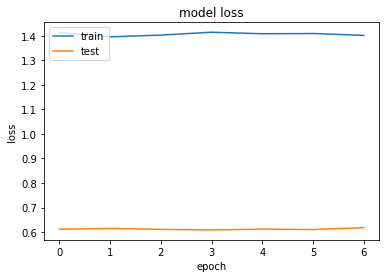

1715/1715 [==============================] - 1s 466us/step
Test loss: 2.01667359104657
Test accuracy: 0.5411078716853617
No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.
***************



Entrenamiento 7
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4089 - acc: 0.6115 - val_loss: 2.3817 - val_acc: 0.4774
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4175 - acc: 0.6126 - val_loss: 2.3817 - val_acc: 0.4774
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4134 - acc: 0.6130 - val_loss: 2.3817 - val_acc: 0.4774
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4116 - acc: 0.6121 - val_loss: 2.3817 - val_acc: 0.4774
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4239 - acc: 0.6066 - val_loss: 2.3817 - val_acc: 0.4774
Epoch 6/11
10972/10972 [===

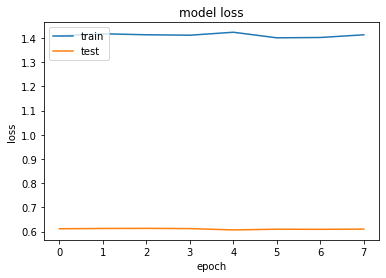

1715/1715 [==============================] - 1s 485us/step
Test loss: 2.016684879575457
Test accuracy: 0.5411078716853617
No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.
***************



Entrenamiento 8
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4238 - acc: 0.6055 - val_loss: 2.3817 - val_acc: 0.4774
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4188 - acc: 0.6117 - val_loss: 2.3817 - val_acc: 0.4774
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4131 - acc: 0.6160 - val_loss: 2.3817 - val_acc: 0.4774
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.3944 - acc: 0.6128 - val_loss: 2.3817 - val_acc: 0.4774
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4165 - acc: 0.6119 - val_loss: 2.3817 - val_acc: 0.4774
Epoch 6/11
10972/10972 [==

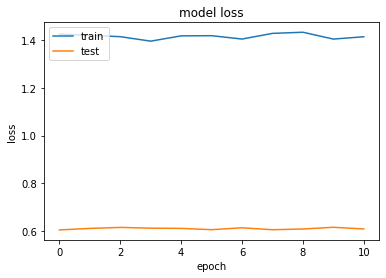

1715/1715 [==============================] - 1s 478us/step
Test loss: 2.0166846817505952
Test accuracy: 0.5411078716853617
No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.
***************



Entrenamiento 9
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4207 - acc: 0.6111 - val_loss: 2.3817 - val_acc: 0.4774
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4272 - acc: 0.6050 - val_loss: 2.3817 - val_acc: 0.4774
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4088 - acc: 0.6108 - val_loss: 2.3817 - val_acc: 0.4774
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4123 - acc: 0.6128 - val_loss: 2.3817 - val_acc: 0.4774
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.4156 - acc: 0.6096 - val_loss: 2.3817 - val_acc: 0.4774
Epoch 6/11
10972/10972 [=

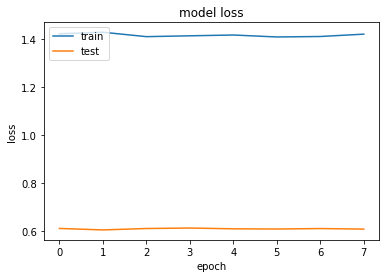

1715/1715 [==============================] - 1s 477us/step
Test loss: 2.016684659507462
Test accuracy: 0.5411078716853617
No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.


In [29]:
#Entreno el modelo
numeroEntrenamientos = 50 #Al final de cada entrenamiento guardo los mejores pesos
numeroEpocas = 11  #ciclos en los cuales evaluo los datos de entrenamiento para hallar los mejores pesos
oldModel = None
oldAccuaricy = 0
conteoFallosEncontrarUnBuenModelo = 0
for i in range(numeroEntrenamientos):     
    print()   
    print()
    print("Entrenamiento " + str(i + 1))

    history = new_model.fit(
        train_X, train_label, 
        batch_size=32, # cantidad de imágenes que se toman a la vez en memoria
        epochs=numeroEpocas, 
        verbose=1,
  
        validation_data=(valid_X, valid_label),
        callbacks=DefineCallback(nombreModeloCreado)
        )
        
    plot_history(history)
    
    test_eval = new_model.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    if oldAccuaricy < test_eval[1]:
        #Buscamos que haya mejora en el modelo, si hay mejora, guardamos el modelo
        oldAccuaricy = test_eval[1]
        modelExtern.GuardarPesosModelo()
        oldModel = new_model
        conteoFallosEncontrarUnBuenModelo = 0
    else:
        #Buscamos que el modelo tenga mejora en por lo menos 3 intentos, si supera tres intentos de entrenamiento sin mejora, se cancela el entrenamiento
        conteoFallosEncontrarUnBuenModelo += 1
        print("No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.")
        new_model = oldModel
        if conteoFallosEncontrarUnBuenModelo > 3:
            break
    print("***************")    
    print()

In [30]:
#valido el modelo
test_eval = new_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

1715/1715 [==============================] - 1s 469us/step
Test loss: 2.016684659507462
Test accuracy: 0.5411078716853617


In [31]:
modelExtern.GuardarPesosModelo()

Pesos Guardados!


True

## 3.3 Cargar Modelo Red Neuronal Guardado (Nueva red neuronal desde cero)

In [50]:
modeloCargado = modelExtern.CargarModeloGuardado(False)
modeloCargado.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

Lectura del Json del modelo correcta
<class 'str'>
Modelo Cargado!
Pesos Cargados!


In [51]:
print("*********************************************************************")
print("*                                                                   *")
print("*                      Modelo Creado desde cero                     *")
print("*                                                                   *")
print("*********************************************************************")
print()
print()

#valido el modelo
test_eval = modeloCargado.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy: %s %%' %( round(test_eval[1]*100, 2)))
print()

#valido el modelo 2
test_eval = modeloCargado.evaluate(X_predic, y_predic, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy: %s %%' %( round(test_eval[1]*100, 2)))
print()

#valido el modelo 3
test_eval = modeloCargado.evaluate(x_all, y_all, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy: %s %%' %( round(test_eval[1]*100, 2)))
print()

*********************************************************************
*                                                                   *
*                      Modelo Creado desde cero                     *
*                                                                   *
*********************************************************************


1715/1715 [==============================] - 4s 3ms/step
Test loss: 2.016684659507462
Test accuracy: 54.11 %

572/572 [==============================] - 0s 501us/step
Test loss: 2.126732486944932
Test accuracy: 52.8 %

9145/9145 [==============================] - 5s 512us/step
Test loss: 1.3222592838938838
Test accuracy: 68.17 %



# 4. Reentrenar un modelo de ImageNet (usando VG16)

In [34]:
ramColab, GpuColab = getRam_y_Gpu(False)
if ramColab < 3:
    print("La Ram disponible no es suficiente para los entrenamientos de la red neuronal.")
else:
    getRam_y_Gpu(True)

Gen RAM Free: 8.9 GB  | Proc size: 22.0 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [0]:
nombreModeloTransferencia = "wisrovi-transferLearning"
modeloTrasnferenciaConocimiento = ModeloExterno(nombreModelo=nombreModeloTransferencia, rutaBase=BASE_FOLDER)

## 4.1 Cargar Modelo ImageNet VGG16

In [36]:
# VGG16, VGG19, ResNet50, 
#Xception, InceptionV3, InceptionResNetV2, 
#MobileNetV2, DenseNet, RasNet


#https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

from keras.applications import VGG16 
conv_base = VGG16(weights='imagenet',
                 include_top=False, # Si se deben incluir o no las capas de salida originales del modelo
                 input_shape=(128,128,3))

conv_base.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________________

## 4.2 Descongelar unas capas del Modelo ImageNet para reentrenarlas

In [37]:
congelarTodoModeloImagenet = False
if congelarTodoModeloImagenet:
  conv_base.trainable = False
else:
  # Freeze the layers except the last 5 layers
  cantidadCapasFinalesDescongelar = 5
  for layer in conv_base.layers[:-cantidadCapasFinalesDescongelar]:
      layer.trainable = False
      pass

  # Check the trainable status of the individual layers
  for layer in conv_base.layers:
      pass
      print(layer, layer.trainable)

conv_base.summary()

<keras.engine.input_layer.InputLayer object at 0x7f11200ba940> False
<keras.layers.convolutional.Conv2D object at 0x7f11200bac18> False
<keras.layers.convolutional.Conv2D object at 0x7f11200ba9b0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f11200c4b38> False
<keras.layers.convolutional.Conv2D object at 0x7f11200d6b70> False
<keras.layers.convolutional.Conv2D object at 0x7f11200d9518> False
<keras.layers.pooling.MaxPooling2D object at 0x7f112005f278> False
<keras.layers.convolutional.Conv2D object at 0x7f1120066978> False
<keras.layers.convolutional.Conv2D object at 0x7f112006cac8> False
<keras.layers.convolutional.Conv2D object at 0x7f1120073828> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1120080198> False
<keras.layers.convolutional.Conv2D object at 0x7f11200888d0> False
<keras.layers.convolutional.Conv2D object at 0x7f112008d9e8> False
<keras.layers.convolutional.Conv2D object at 0x7f1120094748> False
<keras.layers.pooling.MaxPooling2D object at 0x7f11200201d0>

## 4.3. Crear nuestro modelo e incluirle el modelo de imageNet

In [38]:
pre_trained_model = getModelTransferLearning(conv_base)

modeloTrasnferenciaConocimiento.GuardarModelo(pre_trained_model)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 32)          147488    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 102)              

True

## 4.4. Entrenar Modelo Con conocimiento Transferido

Int:  (10972, 128, 128, 3)
Out:  (10972, 102)


Entrenamiento 1


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 17s 2ms/step - loss: 3.0418 - acc: 0.3382 - val_loss: 2.3506 - val_acc: 0.4585
Epoch 2/15
10972/10972 [==============================] - 15s 1ms/step - loss: 2.0131 - acc: 0.5089 - val_loss: 1.6714 - val_acc: 0.5765
Epoch 3/15
10972/10972 [==============================] - 15s 1ms/step - loss: 1.4301 - acc: 0.6281 - val_loss: 1.2794 - val_acc: 0.6647
Epoch 4/15
10972/10972 [==============================] - 15s 1ms/step - loss: 1.0673 - acc: 0.7072 - val_loss: 1.1235 - val_acc: 0.7117
Epoch 5/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.8223 - acc: 0.7725 - val_loss: 1.0366 - val_acc: 0.7278
Epoch 6/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.6426 - acc: 0.8208 - val_loss: 1.0619 - val_acc: 0.7420
Epoch 7/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.5147 - acc: 0.8510 - val_loss: 0.9659 - val_acc:

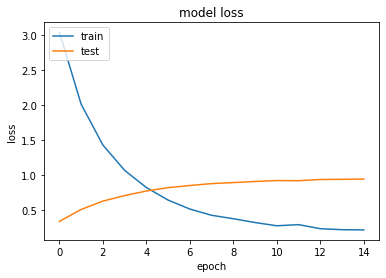

1715/1715 [==============================] - 2s 1ms/step
Test loss: 1.075885049803264
Test accuracy: 0.8093294461336498
Pesos Guardados!
***************



Entrenamiento 2
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
  128/10972 [..............................] - ETA: 13s - loss: 0.1034 - acc: 0.9766

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


10972/10972 [==============================] - 15s 1ms/step - loss: 0.1996 - acc: 0.9487 - val_loss: 0.9647 - val_acc: 0.8047
Epoch 2/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.1440 - acc: 0.9609 - val_loss: 1.0393 - val_acc: 0.8072
Epoch 3/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.1513 - acc: 0.9583 - val_loss: 1.2846 - val_acc: 0.7872
Epoch 4/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.2966 - acc: 0.9326 - val_loss: 1.1744 - val_acc: 0.8010
Epoch 5/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.1831 - acc: 0.9541 - val_loss: 1.0102 - val_acc: 0.8116
Epoch 6/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.1468 - acc: 0.9624 - val_loss: 1.3423 - val_acc: 0.7926
dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


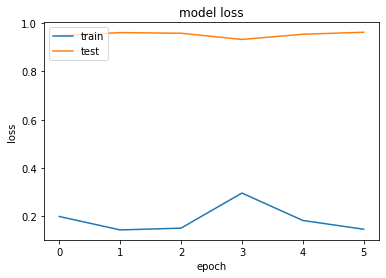

1715/1715 [==============================] - 2s 991us/step
Test loss: 1.54369555951555
Test accuracy: 0.7930029157646891
No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.
***************



Entrenamiento 3
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0776 - acc: 0.9817 - val_loss: 0.9980 - val_acc: 0.8331
Epoch 2/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0317 - acc: 0.9928 - val_loss: 0.9698 - val_acc: 0.8367
Epoch 3/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0215 - acc: 0.9950 - val_loss: 0.9834 - val_acc: 0.8407
Epoch 4/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0164 - acc: 0.9975 - val_loss: 0.9877 - val_acc: 0.8415
Epoch 5/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0150 - acc: 0.9971 - val_loss: 1.0137 - val_acc: 0.8407
Epoch 6/15
10972/10972 [===

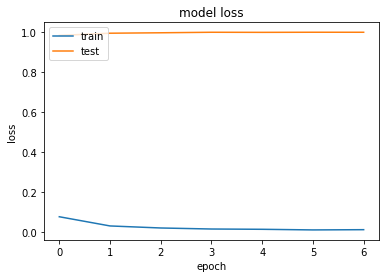

1715/1715 [==============================] - 2s 991us/step
Test loss: 1.2511319669968186
Test accuracy: 0.8314868807792664
Pesos Guardados!
***************



Entrenamiento 4
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0120 - acc: 0.9975 - val_loss: 1.0113 - val_acc: 0.8466
Epoch 2/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0110 - acc: 0.9981 - val_loss: 1.0102 - val_acc: 0.8469
Epoch 3/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0100 - acc: 0.9986 - val_loss: 1.0123 - val_acc: 0.8473
Epoch 4/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0099 - acc: 0.9987 - val_loss: 1.0152 - val_acc: 0.8451
Epoch 5/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0118 - acc: 0.9981 - val_loss: 1.0162 - val_acc: 0.8462
Epoch 6/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0106 - acc

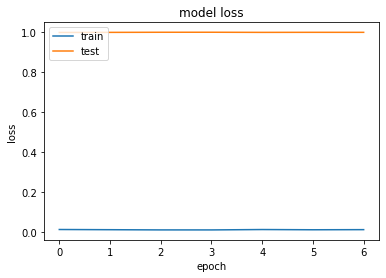

1715/1715 [==============================] - 2s 1ms/step
Test loss: 1.2578200721879742
Test accuracy: 0.8326530615372838
Pesos Guardados!
***************



Entrenamiento 5
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0118 - acc: 0.9979 - val_loss: 1.0195 - val_acc: 0.8437
Epoch 2/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0099 - acc: 0.9987 - val_loss: 1.0195 - val_acc: 0.8437
Epoch 3/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0119 - acc: 0.9982 - val_loss: 1.0194 - val_acc: 0.8440
Epoch 4/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.0093 - acc: 0.9987 - val_loss: 1.0195 - val_acc: 0.8444
Epoch 5/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0115 - acc: 0.9983 - val_loss: 1.0194 - val_acc: 0.8437
Epoch 6/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0113 - acc: 

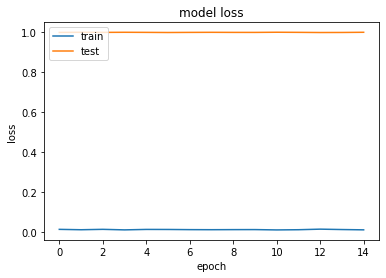

1715/1715 [==============================] - 2s 1ms/step
Test loss: 1.2575619892198213
Test accuracy: 0.8320699711582751
No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.
***************



Entrenamiento 6
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0115 - acc: 0.9983 - val_loss: 1.0175 - val_acc: 0.8440
Epoch 2/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.0108 - acc: 0.9983 - val_loss: 1.0174 - val_acc: 0.8440
Epoch 3/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.0096 - acc: 0.9987 - val_loss: 1.0173 - val_acc: 0.8440
Epoch 4/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0101 - acc: 0.9985 - val_loss: 1.0171 - val_acc: 0.8444
Epoch 5/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0117 - acc: 0.9984 - val_loss: 1.0174 - val_acc: 0.8444
Epoch 6/15
10972/10972 [===

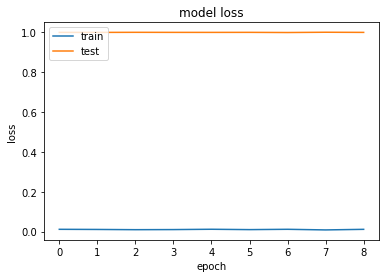

1715/1715 [==============================] - 2s 1ms/step
Test loss: 1.2560807829348062
Test accuracy: 0.8332361519162926
Pesos Guardados!
***************



Entrenamiento 7
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0102 - acc: 0.9986 - val_loss: 1.0182 - val_acc: 0.8440
Epoch 2/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0113 - acc: 0.9985 - val_loss: 1.0182 - val_acc: 0.8440
Epoch 3/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0103 - acc: 0.9983 - val_loss: 1.0182 - val_acc: 0.8440
Epoch 4/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0093 - acc: 0.9989 - val_loss: 1.0182 - val_acc: 0.8440
Epoch 5/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0099 - acc: 0.9987 - val_loss: 1.0181 - val_acc: 0.8440
Epoch 6/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0119 - acc: 

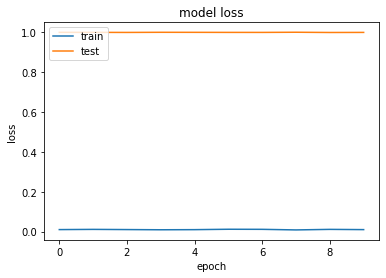

1715/1715 [==============================] - 2s 1ms/step
Test loss: 1.2562268593568495
Test accuracy: 0.8326530615372838
No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.
***************



Entrenamiento 8
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0101 - acc: 0.9984 - val_loss: 1.0182 - val_acc: 0.8437
Epoch 2/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0099 - acc: 0.9985 - val_loss: 1.0182 - val_acc: 0.8437
Epoch 3/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0093 - acc: 0.9987 - val_loss: 1.0182 - val_acc: 0.8437
Epoch 4/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0086 - acc: 0.9990 - val_loss: 1.0182 - val_acc: 0.8437
Epoch 5/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0103 - acc: 0.9985 - val_loss: 1.0182 - val_acc: 0.8437
Epoch 6/15
10972/10972 [===

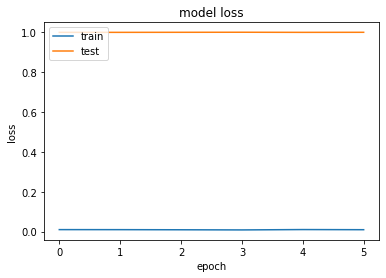

1715/1715 [==============================] - 2s 1ms/step
Test loss: 1.2562303710609415
Test accuracy: 0.8326530615372838
No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.
***************



Entrenamiento 9
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0095 - acc: 0.9986 - val_loss: 1.0182 - val_acc: 0.8437
Epoch 2/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0107 - acc: 0.9985 - val_loss: 1.0182 - val_acc: 0.8437
Epoch 3/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.0104 - acc: 0.9985 - val_loss: 1.0182 - val_acc: 0.8437
Epoch 4/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0116 - acc: 0.9981 - val_loss: 1.0182 - val_acc: 0.8437
Epoch 5/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0093 - acc: 0.9987 - val_loss: 1.0182 - val_acc: 0.8437
Epoch 6/15
10972/10972 [===

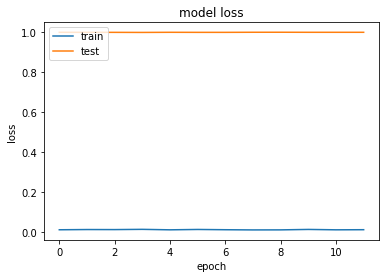

1715/1715 [==============================] - 2s 1ms/step
Test loss: 1.2562304382073983
Test accuracy: 0.8326530615372838
No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.
***************



Entrenamiento 10
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0090 - acc: 0.9990 - val_loss: 1.0182 - val_acc: 0.8437
Epoch 2/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0102 - acc: 0.9982 - val_loss: 1.0182 - val_acc: 0.8437
Epoch 3/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0102 - acc: 0.9985 - val_loss: 1.0182 - val_acc: 0.8437
Epoch 4/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0090 - acc: 0.9989 - val_loss: 1.0182 - val_acc: 0.8437
Epoch 5/15
10972/10972 [==============================] - 15s 1ms/step - loss: 0.0099 - acc: 0.9984 - val_loss: 1.0182 - val_acc: 0.8437
Epoch 6/15
10972/10972 [==

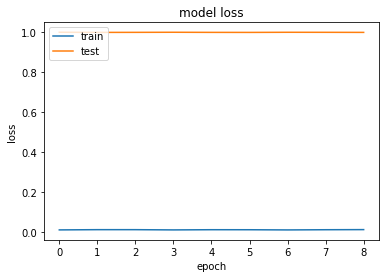

1715/1715 [==============================] - 2s 1ms/step
Test loss: 1.2562305069525805
Test accuracy: 0.8326530615372838
No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.


In [39]:
#Entreno el modelo

#Al final de cada entrenamiento guardo los mejores pesos
numeroEntrenamientos = 30

#ciclos en los cuales evaluo los datos de entrenamiento para hallar los mejores pesos
numeroEpocas = 15

#ver datos entrenamiento
print("Int: ", train_X.shape)
print("Out: ", train_label.shape)

oldModel = None
oldAccuaricy = 0
conteoFallosEncontrarUnBuenModelo = 0
for i in range(numeroEntrenamientos):     
    print()   
    print()
    print("Entrenamiento " + str(i + 1))

    history = pre_trained_model.fit(
        train_X, train_label, 
        batch_size=64, # cantidad de imágenes que se toman a la vez en memoria
        epochs=numeroEpocas,        
        verbose=1,
        validation_data=(valid_X, valid_label),
        callbacks=DefineCallback(nombreModeloTransferencia)
        )
        
    plot_history(history)   

    test_eval = pre_trained_model.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    if oldAccuaricy < test_eval[1]:
        #Buscamos que haya mejora en el modelo, si hay mejora, guardamos el modelo
        oldAccuaricy = test_eval[1]
        modeloTrasnferenciaConocimiento.GuardarPesosModelo()
        oldModel = pre_trained_model
        conteoFallosEncontrarUnBuenModelo = 0
    else:
        #Buscamos que el modelo tenga mejora en por lo menos 3 intentos, si supera tres intentos de entrenamiento sin mejora, se cancela el entrenamiento
        conteoFallosEncontrarUnBuenModelo += 1
        pre_trained_model = oldModel
        print("No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.")
        if conteoFallosEncontrarUnBuenModelo > 3:
            break
    print("***************")    
    print()

## 4.5. Cargar Modelo Red Neuronal Guardado (Transferencia conocimiento)

In [52]:
modeloCargadoTransferenciaConocimiento = modeloTrasnferenciaConocimiento.CargarModeloGuardado(False)
modeloCargadoTransferenciaConocimiento.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

Lectura del Json del modelo correcta
<class 'str'>
Modelo Cargado!
Pesos Cargados!


In [53]:
print("*********************************************************************")
print("*                                                                   *")
print("*           Modelo basado en transferencia de conocimiento          *")
print("*                                                                   *")
print("*********************************************************************")
print()
print()

#valido el modelo
test_eval = modeloCargadoTransferenciaConocimiento.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy: %s %%' %( round(test_eval[1]*100, 2)))
print()

#valido el modelo 2
test_eval = modeloCargadoTransferenciaConocimiento.evaluate(X_predic, y_predic, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy: %s %%' %( round(test_eval[1]*100, 2)))
print()

#valido el modelo 3
test_eval = modeloCargadoTransferenciaConocimiento.evaluate(x_all, y_all, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy: %s %%' %( round(test_eval[1]*100, 2)))
print()

*********************************************************************
*                                                                   *
*           Modelo basado en transferencia de conocimiento          *
*                                                                   *
*********************************************************************


1715/1715 [==============================] - 5s 3ms/step
Test loss: 1.2560807829348062
Test accuracy: 83.32 %

572/572 [==============================] - 1s 1ms/step
Test loss: 1.4108595881428752
Test accuracy: 81.29 %

9145/9145 [==============================] - 10s 1ms/step
Test loss: 0.4419296302206416
Test accuracy: 93.99 %



# 5. Reentrenar un modelo de ImageNet (usando MobileNetV2)

In [42]:
ramColab, GpuColab = getRam_y_Gpu(False)
if ramColab < 3:
    print("La Ram disponible no es suficiente para los entrenamientos de la red neuronal.")
else:
    getRam_y_Gpu(True)

Gen RAM Free: 5.5 GB  | Proc size: 22.3 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [0]:
nombreModeloTransferencia2 = "wisrovi-transferLearning-2"
modeloTrasnferenciaConocimiento2 = ModeloExterno(nombreModelo=nombreModeloTransferencia2, rutaBase=BASE_FOLDER)

## 5.1. Cargar Modelo ImageNet MobileNetV2 

In [44]:
# VGG16, VGG19, ResNet50, 
#Xception, InceptionV3, InceptionResNetV2, 
#MobileNetV2, DenseNet, RasNet


#https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

from keras.applications import MobileNetV2 
conv_base = MobileNetV2(weights='imagenet',
                 include_top=False, # Si se deben incluir o no las capas de salida originales del modelo
                 input_shape=(128,128,3))

conv_base.summary()


Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
______________________________________________________________________________

## 5.2. Descongelar unas capas del Modelo ImageNet para reentrenarlas

In [45]:
congelarTodoModeloImagenet = False
if congelarTodoModeloImagenet:
  conv_base.trainable = False
else:
  # Freeze the layers except the last 5 layers
  cantidadCapasFinalesDescongelar = 5
  for layer in conv_base.layers[:-cantidadCapasFinalesDescongelar]:
      layer.trainable = False
      pass

  # Check the trainable status of the individual layers
  for layer in conv_base.layers:
      pass
      print(layer, layer.trainable)

conv_base.summary()

<keras.engine.input_layer.InputLayer object at 0x7f0fd3a05828> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f0fd3a05be0> False
<keras.layers.convolutional.Conv2D object at 0x7f0fd3a05940> False
<keras.layers.normalization.BatchNormalization object at 0x7f10c41bf2e8> False
<keras.layers.advanced_activations.ReLU object at 0x7f0fd3a04588> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f0fd3a04a20> False
<keras.layers.normalization.BatchNormalization object at 0x7f113985ea90> False
<keras.layers.advanced_activations.ReLU object at 0x7f1139709b70> False
<keras.layers.convolutional.Conv2D object at 0x7f113973fe80> False
<keras.layers.normalization.BatchNormalization object at 0x7f112818cc50> False
<keras.layers.convolutional.Conv2D object at 0x7f112818c7f0> False
<keras.layers.normalization.BatchNormalization object at 0x7f0fd3ab4f60> False
<keras.layers.advanced_activations.ReLU object at 0x7f0fd3aa66d8> False
<keras.layers.convolutional.ZeroPadding2D object

## 5.3. Crear nuestro modelo e incluirle el modelo de imageNet

In [46]:
pre_trained_model_2 = getModelTransferLearning(conv_base)

modeloTrasnferenciaConocimiento2.GuardarModelo(pre_trained_model_2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 1280)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 32)          368672    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 32)          9248      
_________________________________________________________________
dropout_7 (Dropout)          (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 102)              

True

## 5.4. Entrenar Modelo Con conocimiento Transferido

Int:  (10972, 128, 128, 3)
Out:  (10972, 102)


Entrenamiento 1


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 14s 1ms/step - loss: 2.1223 - acc: 0.5133 - val_loss: 2.8251 - val_acc: 0.4832
Epoch 2/15
10972/10972 [==============================] - 10s 866us/step - loss: 1.0758 - acc: 0.7173 - val_loss: 2.2481 - val_acc: 0.5689
Epoch 3/15
10972/10972 [==============================] - 10s 867us/step - loss: 0.7954 - acc: 0.7863 - val_loss: 2.9607 - val_acc: 0.5463
Epoch 4/15
10972/10972 [==============================] - 9s 864us/step - loss: 0.6357 - acc: 0.8277 - val_loss: 3.5042 - val_acc: 0.5040
Epoch 5/15
10972/10972 [==============================] - 9s 857us/step - loss: 0.5438 - acc: 0.8456 - val_loss: 3.2272 - val_acc: 0.5620
Epoch 6/15
10972/10972 [==============================] - 9s 863us/step - loss: 0.4946 - acc: 0.8630 - val_loss: 2.1672 - val_acc: 0.6327
Epoch 7/15
10972/10972 [==============================] - 9s 860us/step - loss: 0.4271 - acc: 0.8804 - val_loss: 2.7526 - 

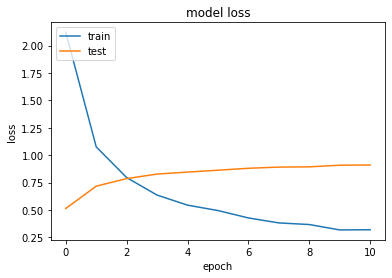

1715/1715 [==============================] - 1s 688us/step
Test loss: 2.1128223556818835
Test accuracy: 0.7032069971540579
Pesos Guardados!
***************



Entrenamiento 2
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
  224/10972 [..............................] - ETA: 7s - loss: 0.3169 - acc: 0.9018

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


10972/10972 [==============================] - 10s 870us/step - loss: 0.1829 - acc: 0.9448 - val_loss: 2.3124 - val_acc: 0.6713
Epoch 2/15
10972/10972 [==============================] - 10s 866us/step - loss: 0.1259 - acc: 0.9606 - val_loss: 2.0984 - val_acc: 0.6946
Epoch 3/15
10972/10972 [==============================] - 9s 865us/step - loss: 0.1121 - acc: 0.9650 - val_loss: 1.8424 - val_acc: 0.7117
Epoch 4/15
10972/10972 [==============================] - 10s 868us/step - loss: 0.0823 - acc: 0.9752 - val_loss: 1.8288 - val_acc: 0.7150
Epoch 5/15
10972/10972 [==============================] - 10s 869us/step - loss: 0.0770 - acc: 0.9743 - val_loss: 1.7399 - val_acc: 0.7296
Epoch 6/15
10972/10972 [==============================] - 10s 872us/step - loss: 0.0771 - acc: 0.9749 - val_loss: 1.8063 - val_acc: 0.7249
Epoch 7/15
10972/10972 [==============================] - 10s 871us/step - loss: 0.0736 - acc: 0.9788 - val_loss: 1.8539 - val_acc: 0.7190
Epoch 8/15
10972/10972 [===============

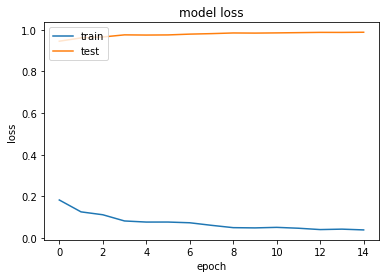

1715/1715 [==============================] - 1s 632us/step
Test loss: 1.2930129198569251
Test accuracy: 0.8099125367559428
Pesos Guardados!
***************



Entrenamiento 3
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 9s 863us/step - loss: 0.0372 - acc: 0.9892 - val_loss: 1.7624 - val_acc: 0.7423
Epoch 2/15
10972/10972 [==============================] - 10s 873us/step - loss: 0.0348 - acc: 0.9889 - val_loss: 1.7756 - val_acc: 0.7405
Epoch 3/15
10972/10972 [==============================] - 10s 866us/step - loss: 0.0381 - acc: 0.9889 - val_loss: 1.7496 - val_acc: 0.7423
Epoch 4/15
10972/10972 [==============================] - 10s 870us/step - loss: 0.0339 - acc: 0.9893 - val_loss: 1.7487 - val_acc: 0.7402
Epoch 5/15
10972/10972 [==============================] - 10s 890us/step - loss: 0.0360 - acc: 0.9884 - val_loss: 1.7443 - val_acc: 0.7416
Epoch 6/15
10972/10972 [==============================] - 10s 871us/step - loss: 0

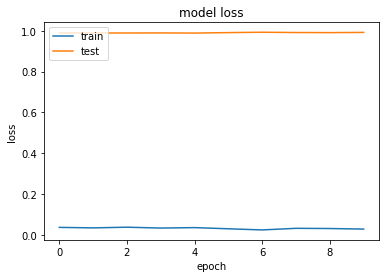

1715/1715 [==============================] - 1s 628us/step
Test loss: 1.2831378488429435
Test accuracy: 0.8139941694090039
Pesos Guardados!
***************



Entrenamiento 4
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 9s 862us/step - loss: 0.0266 - acc: 0.9906 - val_loss: 1.7485 - val_acc: 0.7431
Epoch 2/15
10972/10972 [==============================] - 10s 868us/step - loss: 0.0335 - acc: 0.9895 - val_loss: 1.7446 - val_acc: 0.7427
Epoch 3/15
10972/10972 [==============================] - 10s 866us/step - loss: 0.0309 - acc: 0.9912 - val_loss: 1.7429 - val_acc: 0.7431
Epoch 4/15
10972/10972 [==============================] - 10s 867us/step - loss: 0.0246 - acc: 0.9927 - val_loss: 1.7438 - val_acc: 0.7423
Epoch 5/15
10972/10972 [==============================] - 9s 864us/step - loss: 0.0310 - acc: 0.9902 - val_loss: 1.7428 - val_acc: 0.7427
Epoch 6/15
10972/10972 [==============================] - 10s 867us/step - loss: 0.

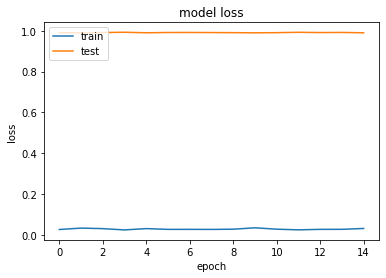

1715/1715 [==============================] - 1s 650us/step
Test loss: 1.276196557926367
Test accuracy: 0.8151603501670215
Pesos Guardados!
***************



Entrenamiento 5
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 10s 872us/step - loss: 0.0299 - acc: 0.9906 - val_loss: 1.7398 - val_acc: 0.7423
Epoch 2/15
10972/10972 [==============================] - 10s 871us/step - loss: 0.0281 - acc: 0.9921 - val_loss: 1.7404 - val_acc: 0.7427
Epoch 3/15
10972/10972 [==============================] - 10s 869us/step - loss: 0.0293 - acc: 0.9910 - val_loss: 1.7420 - val_acc: 0.7423
Epoch 4/15
10972/10972 [==============================] - 10s 875us/step - loss: 0.0304 - acc: 0.9900 - val_loss: 1.7435 - val_acc: 0.7431
Epoch 5/15
10972/10972 [==============================] - 10s 885us/step - loss: 0.0266 - acc: 0.9921 - val_loss: 1.7427 - val_acc: 0.7431
Epoch 6/15
10972/10972 [==============================] - 10s 872us/step - loss: 0

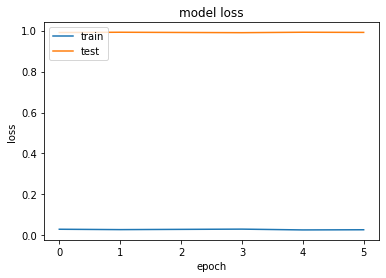

1715/1715 [==============================] - 1s 636us/step
Test loss: 1.276805356084084
Test accuracy: 0.8151603501670215
No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.
***************



Entrenamiento 6
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 10s 870us/step - loss: 0.0284 - acc: 0.9908 - val_loss: 1.7418 - val_acc: 0.7431
Epoch 2/15
10972/10972 [==============================] - 10s 872us/step - loss: 0.0290 - acc: 0.9912 - val_loss: 1.7406 - val_acc: 0.7431
Epoch 3/15
10972/10972 [==============================] - 10s 873us/step - loss: 0.0304 - acc: 0.9905 - val_loss: 1.7400 - val_acc: 0.7431
Epoch 4/15
10972/10972 [==============================] - 10s 870us/step - loss: 0.0282 - acc: 0.9911 - val_loss: 1.7404 - val_acc: 0.7434
Epoch 5/15
10972/10972 [==============================] - 10s 877us/step - loss: 0.0278 - acc: 0.9913 - val_loss: 1.7419 - val_acc: 0.7431
Epoch 6/15
10972

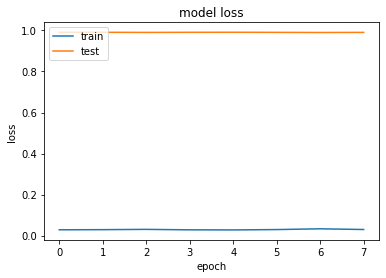

1715/1715 [==============================] - 1s 639us/step
Test loss: 1.275807117581715
Test accuracy: 0.8151603501670215
No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.
***************



Entrenamiento 7
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 10s 868us/step - loss: 0.0247 - acc: 0.9923 - val_loss: 1.7410 - val_acc: 0.7431
Epoch 2/15
10972/10972 [==============================] - 10s 871us/step - loss: 0.0346 - acc: 0.9898 - val_loss: 1.7411 - val_acc: 0.7431
Epoch 3/15
10972/10972 [==============================] - 10s 869us/step - loss: 0.0329 - acc: 0.9908 - val_loss: 1.7414 - val_acc: 0.7431
Epoch 4/15
10972/10972 [==============================] - 10s 873us/step - loss: 0.0277 - acc: 0.9921 - val_loss: 1.7408 - val_acc: 0.7431
Epoch 5/15
10972/10972 [==============================] - 10s 875us/step - loss: 0.0263 - acc: 0.9918 - val_loss: 1.7410 - val_acc: 0.7431
Epoch 6/15
10972

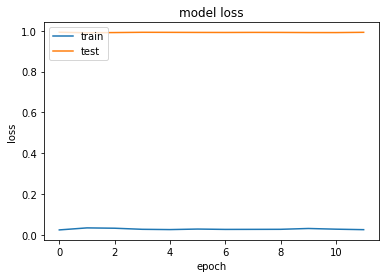

1715/1715 [==============================] - 1s 634us/step
Test loss: 1.2767296063309161
Test accuracy: 0.8151603501670215
No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.
***************



Entrenamiento 8
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 10s 869us/step - loss: 0.0289 - acc: 0.9912 - val_loss: 1.7425 - val_acc: 0.7431
Epoch 2/15
10972/10972 [==============================] - 10s 877us/step - loss: 0.0320 - acc: 0.9903 - val_loss: 1.7426 - val_acc: 0.7427
Epoch 3/15
10972/10972 [==============================] - 10s 868us/step - loss: 0.0279 - acc: 0.9907 - val_loss: 1.7415 - val_acc: 0.7431
Epoch 4/15
10972/10972 [==============================] - 10s 866us/step - loss: 0.0319 - acc: 0.9907 - val_loss: 1.7411 - val_acc: 0.7431
Epoch 5/15
10972/10972 [==============================] - 10s 871us/step - loss: 0.0257 - acc: 0.9924 - val_loss: 1.7405 - val_acc: 0.7431
Epoch 6/15
1097

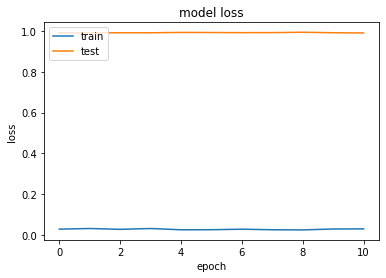

1715/1715 [==============================] - 1s 667us/step
Test loss: 1.2758194642581329
Test accuracy: 0.8157434405460302
Pesos Guardados!
***************



Entrenamiento 9
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 10s 874us/step - loss: 0.0277 - acc: 0.9908 - val_loss: 1.7425 - val_acc: 0.7431
Epoch 2/15
10972/10972 [==============================] - 10s 869us/step - loss: 0.0295 - acc: 0.9913 - val_loss: 1.7422 - val_acc: 0.7431
Epoch 3/15
10972/10972 [==============================] - 10s 874us/step - loss: 0.0275 - acc: 0.9923 - val_loss: 1.7415 - val_acc: 0.7431
Epoch 4/15
10972/10972 [==============================] - 10s 873us/step - loss: 0.0290 - acc: 0.9915 - val_loss: 1.7406 - val_acc: 0.7431
Epoch 5/15
10972/10972 [==============================] - 9s 866us/step - loss: 0.0291 - acc: 0.9902 - val_loss: 1.7403 - val_acc: 0.7431
Epoch 6/15
10972/10972 [==============================] - 10s 883us/step - loss: 0

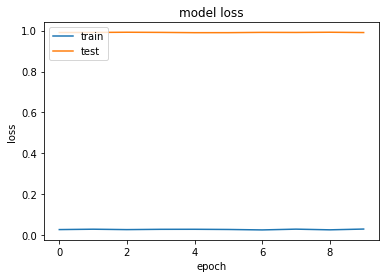

1715/1715 [==============================] - 1s 625us/step
Test loss: 1.2753693671685267
Test accuracy: 0.8157434405460302
No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.
***************



Entrenamiento 10
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 10s 871us/step - loss: 0.0283 - acc: 0.9908 - val_loss: 1.7418 - val_acc: 0.7431
Epoch 2/15
10972/10972 [==============================] - 10s 867us/step - loss: 0.0316 - acc: 0.9902 - val_loss: 1.7412 - val_acc: 0.7431
Epoch 3/15
10972/10972 [==============================] - 9s 865us/step - loss: 0.0289 - acc: 0.9914 - val_loss: 1.7417 - val_acc: 0.7431
Epoch 4/15
10972/10972 [==============================] - 9s 865us/step - loss: 0.0276 - acc: 0.9908 - val_loss: 1.7416 - val_acc: 0.7431
Epoch 5/15
10972/10972 [==============================] - 10s 867us/step - loss: 0.0289 - acc: 0.9921 - val_loss: 1.7408 - val_acc: 0.7431
Epoch 6/15
10972

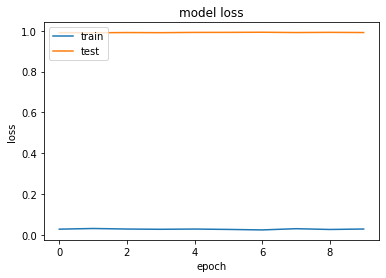

1715/1715 [==============================] - 1s 637us/step
Test loss: 1.2756046668433587
Test accuracy: 0.8157434405460302
No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.
***************



Entrenamiento 11
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 10s 870us/step - loss: 0.0267 - acc: 0.9914 - val_loss: 1.7420 - val_acc: 0.7431
Epoch 2/15
10972/10972 [==============================] - 10s 872us/step - loss: 0.0262 - acc: 0.9923 - val_loss: 1.7420 - val_acc: 0.7431
Epoch 3/15
10972/10972 [==============================] - 10s 868us/step - loss: 0.0300 - acc: 0.9902 - val_loss: 1.7417 - val_acc: 0.7431
Epoch 4/15
10972/10972 [==============================] - 10s 874us/step - loss: 0.0289 - acc: 0.9910 - val_loss: 1.7418 - val_acc: 0.7431
Epoch 5/15
10972/10972 [==============================] - 10s 869us/step - loss: 0.0314 - acc: 0.9902 - val_loss: 1.7420 - val_acc: 0.7431
Epoch 6/15
109

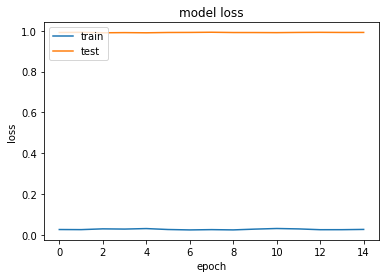

1715/1715 [==============================] - 1s 634us/step
Test loss: 1.2755005312383
Test accuracy: 0.8157434405460302
No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.
***************



Entrenamiento 12
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 10s 869us/step - loss: 0.0296 - acc: 0.9916 - val_loss: 1.7409 - val_acc: 0.7431
Epoch 2/15
10972/10972 [==============================] - 10s 866us/step - loss: 0.0305 - acc: 0.9916 - val_loss: 1.7413 - val_acc: 0.7431
Epoch 3/15
10972/10972 [==============================] - 10s 877us/step - loss: 0.0271 - acc: 0.9917 - val_loss: 1.7410 - val_acc: 0.7431
Epoch 4/15
10972/10972 [==============================] - 10s 874us/step - loss: 0.0258 - acc: 0.9925 - val_loss: 1.7406 - val_acc: 0.7431
Epoch 5/15
10972/10972 [==============================] - 10s 870us/step - loss: 0.0239 - acc: 0.9920 - val_loss: 1.7415 - val_acc: 0.7431
Epoch 6/15
10972/

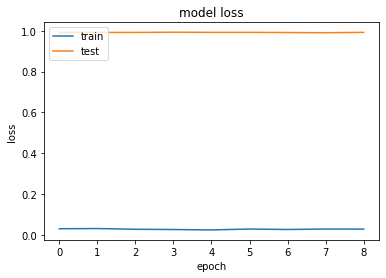

1715/1715 [==============================] - 1s 641us/step
Test loss: 1.2757518763444862
Test accuracy: 0.8151603501670215
No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.


In [47]:
#Entreno el modelo

#Al final de cada entrenamiento guardo los mejores pesos
numeroEntrenamientos = 30

#ciclos en los cuales evaluo los datos de entrenamiento para hallar los mejores pesos
numeroEpocas = 15

#ver datos entrenamiento
print("Int: ", train_X.shape)
print("Out: ", train_label.shape)

oldModel = None
oldAccuaricy = 0
conteoFallosEncontrarUnBuenModelo = 0
for i in range(numeroEntrenamientos):     
    print()   
    print()
    print("Entrenamiento " + str(i + 1))

    history = pre_trained_model_2.fit(
        train_X, train_label, 
        batch_size=32, # cantidad de imágenes que se toman a la vez en memoria
        epochs=numeroEpocas,        
        verbose=1,
        validation_data=(valid_X, valid_label),
        callbacks=DefineCallback(nombreModeloTransferencia2)
        )
        
    plot_history(history)   

    test_eval = pre_trained_model_2.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    if oldAccuaricy < test_eval[1]:
        #Buscamos que haya mejora en el modelo, si hay mejora, guardamos el modelo
        oldAccuaricy = test_eval[1]
        modeloTrasnferenciaConocimiento2.GuardarPesosModelo()
        oldModel = pre_trained_model_2
        conteoFallosEncontrarUnBuenModelo = 0
    else:
        #Buscamos que el modelo tenga mejora en por lo menos 3 intentos, si supera tres intentos de entrenamiento sin mejora, se cancela el entrenamiento
        conteoFallosEncontrarUnBuenModelo += 1
        pre_trained_model_2 = oldModel
        print("No se ha encontrado mejora al modelo, por lo cual se conservan el modelo anterior.")
        if conteoFallosEncontrarUnBuenModelo > 3:
            break
    print("***************")    
    print()

## 5.5. Cargar Modelo Red Neuronal Guardado (Transferencia conocimiento)

In [54]:
modeloCargadoTransferenciaConocimiento2 = modeloTrasnferenciaConocimiento2.CargarModeloGuardado(False)
modeloCargadoTransferenciaConocimiento2.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

Lectura del Json del modelo correcta
<class 'str'>
Modelo Cargado!
Pesos Cargados!


In [55]:
print("*********************************************************************")
print("*                                                                   *")
print("*          Modelo basado en transferencia de conocimiento 2         *")
print("*                                                                   *")
print("*********************************************************************")
print()
print()

#valido el modelo
test_eval = modeloCargadoTransferenciaConocimiento2.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy: %s %%' %( round(test_eval[1]*100, 2)))
print()

#valido el modelo 2
test_eval = modeloCargadoTransferenciaConocimiento2.evaluate(X_predic, y_predic, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy: %s %%' %( round(test_eval[1]*100, 2)))
print()

#valido el modelo 3
test_eval = modeloCargadoTransferenciaConocimiento2.evaluate(x_all, y_all, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy: %s %%' %( round(test_eval[1]*100, 2)))
print()

*********************************************************************
*                                                                   *
*          Modelo basado en transferencia de conocimiento 2         *
*                                                                   *
*********************************************************************


1715/1715 [==============================] - 7s 4ms/step
Test loss: 1.2758194642581329
Test accuracy: 81.57 %

572/572 [==============================] - 0s 704us/step
Test loss: 1.1890678022291277
Test accuracy: 82.17 %

9145/9145 [==============================] - 6s 707us/step
Test loss: 0.8699435855401454
Test accuracy: 85.49 %



# 6. Conclusiones

Al usar la transferencia de conocimiento es más facil alcanzar un modelo de clasificacion óptimo para el objetivo propuesto en pocas epocas de reentrenamiento

Al implementar un aumento de dataset con imageDataGenerator los modelos se entrenan con datos mas generales y esto logra que el modelo sea mas eficiente al predecir datos que no se mostraron durante el entrenamiento

Mientras que para el modelo creado desde cero se ha logrado una precisión de 68.17%, para el modelo de trasnsferencia de conocimiento con VGG16 fue de 93.99% y para el modelo de transferencia de conocimiento con MobileNetV2 una precisión de 85.49%.... con esto hemos encontrado que para este conjunto de datos el modelo por transferencia de conocimiento es el mas adecuado siendo el VGG16 el más óptimo, facil de diseñar y rápido de implementar.